In [18]:
%pip install imageio

     |████████████████████████████████| 3.3MB 3.4MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
import random
import tensorflow as tf
import imageio

In [4]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels

In [5]:
def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

In [115]:
class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        labels_images=[]

        for i in range(batch_size):
            paths=random.sample(character_folders, self.num_classes)
            labels=np.eye(self.num_classes).tolist()
            for j in range(self.num_samples_per_class):
                labels_images.extend(get_images(paths, labels, 1, shuffle=True))

        all_image_batches=[image_file_to_array(label_image[1],784) for label_image in labels_images] 
        all_label_batches=[label_image[0] for label_image in labels_images]
        all_image_batches=np.reshape(all_image_batches,(batch_size, self.num_samples_per_class, self.num_classes, 784))
        all_label_batches=np.reshape(all_label_batches, (batch_size, self.num_samples_per_class, self.num_classes, self.num_classes))
        #############################

        return all_image_batches, all_label_batches

In [132]:
def test_data_generator(batch_size, num_classes, num_samples_per_class):
    """
        test the DataGenerator class's sample_batch function
    Args:
        batch size, number of classes, number of samples per class
    Returns:
        nothing, prints images
    """
    data_generator = DataGenerator(num_classes, num_samples_per_class + 1)
    print('Testing data generator for ', num_samples_per_class, 'shot ', num_classes, \
          'way meta-learner with a batch size', batch_size)
    train_image_batch, train_label_batch = data_generator.sample_batch('train', batch_size)
    print('train image batch shape is ', train_image_batch.shape)
    print('train label batch shape is ', train_label_batch.shape)
    val_image_batch, val_label_batch = data_generator.sample_batch('val', batch_size)
    print('val image batch shape is ', val_image_batch.shape)
    print('val label batch shape is ', val_label_batch.shape)
    test_image_batch, test_label_batch = data_generator.sample_batch('test', batch_size)
    print('test image batch shape is ', test_image_batch.shape)
    print('test label batch shape is ', test_label_batch.shape)
    return

test_data_generator(16,5,1)


Testing data generator for  1 shot  5 way meta-learner with a batch size 16
train image batch shape is  (16, 2, 5, 784)
train label batch shape is  (16, 2, 5, 5)
val image batch shape is  (16, 2, 5, 784)
val label batch shape is  (16, 2, 5, 5)
test image batch shape is  (16, 2, 5, 784)
test label batch shape is  (16, 2, 5, 5)


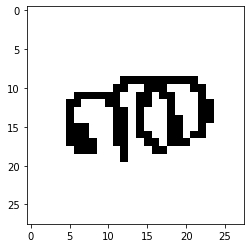

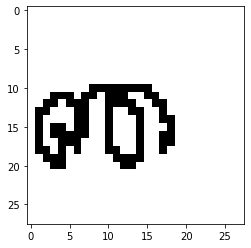

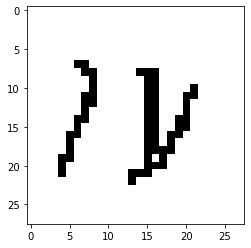

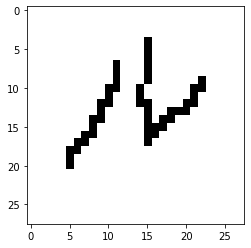

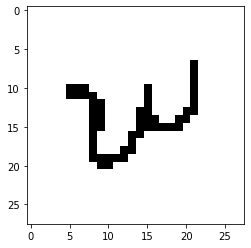

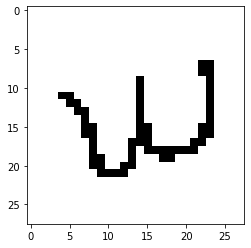

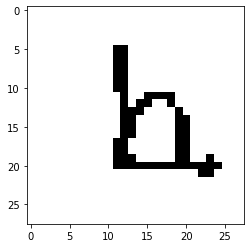

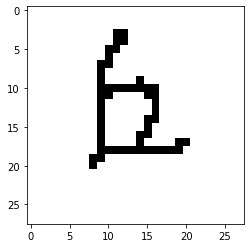

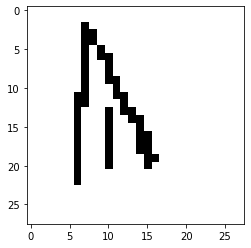

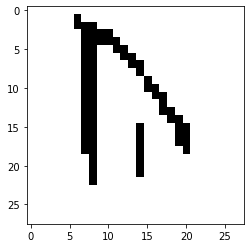

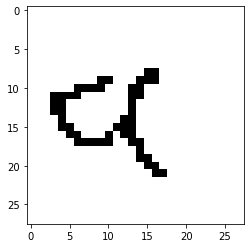

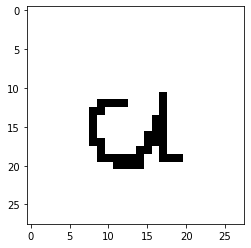

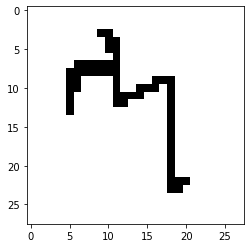

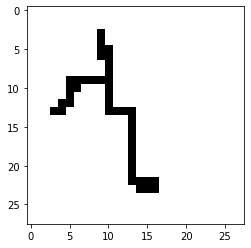

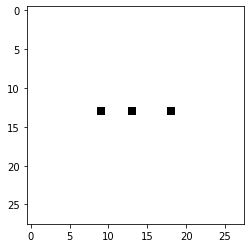

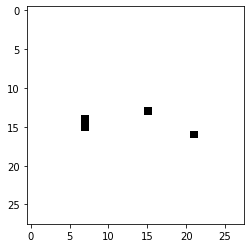

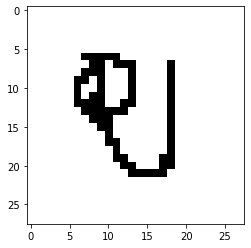

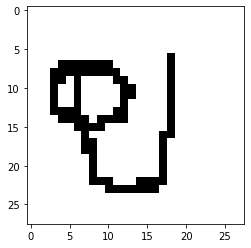

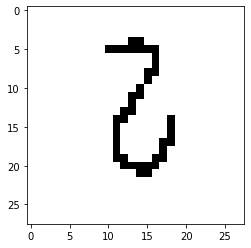

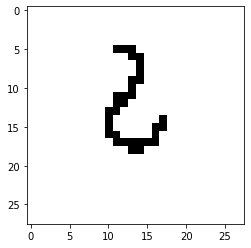

In [130]:
from PIL import Image
import matplotlib.pyplot as plt

def view_omniglot_imgfiles(n_characters, n_images_pchar, data_folder = './omniglot_resized'):
    """
        view random multiple omniglot image files, for demo purposes
    Args:
        number of characters, number of images per character, data folder [ex. ./omniglot_resized]
    Returns:
        nothing, prints images
    """
    character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]
    
    paths=random.sample(character_folders, n_characters)
    labels=np.eye(n_characters).tolist()
    labels_images=get_images(paths, labels, n_images_pchar, shuffle=False)    
    image_files =[label_image[1] for label_image in labels_images]

    for image_file in image_files:
        img=Image.open(image_file)
        plt.figure()
        plt.imshow(img)
    return

view_omniglot_imgfiles(10, 2)
